# Mask R-CNN Demo

This notebook shows how to use the Mask R-CNN model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import scipy.misc
import matplotlib
import matplotlib.pyplot as plt

import coco
import common
import model as modellib
import visualize

%matplotlib inline 

ROOT_DIR = os.getcwd()
MODEL_DIR = ROOT_DIR

Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations for this model are in the ```CocoConfig``` class in ```coco.py```. 

For inferencing, we modify the configurations a bit to fit the task. To do so, we sub-class the ```CocoConfig``` class and override a few attributes.

In [2]:
class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    USE_MINI_MASK = False  # To get full masks from the data generator
    
    # Override some configurations for better result visualization
    # Don't use this when running COCO benchmarks
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD = 0.3
    
    # Get more anchors during inference
    RPN_ANCHOR_STRIDE = 1

config = InferenceConfig()
config.print()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.02
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_DETECTIONS                 100
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.68   116.779  103.939]
MINI_MASK_SHAPE                (56, 56)
NAME                           COCO
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_T

## Build Model and Load Trained Weights

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", config=config)

# Load weights trained on MS-COCO
path = os.path.join(MODEL_DIR, "mask_rcnn_coco.h5")
model.load_weights(path, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [4]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

Scaling Factore: 1.6
one image_meta:  (89,)
1/1 [==============================] - 28s


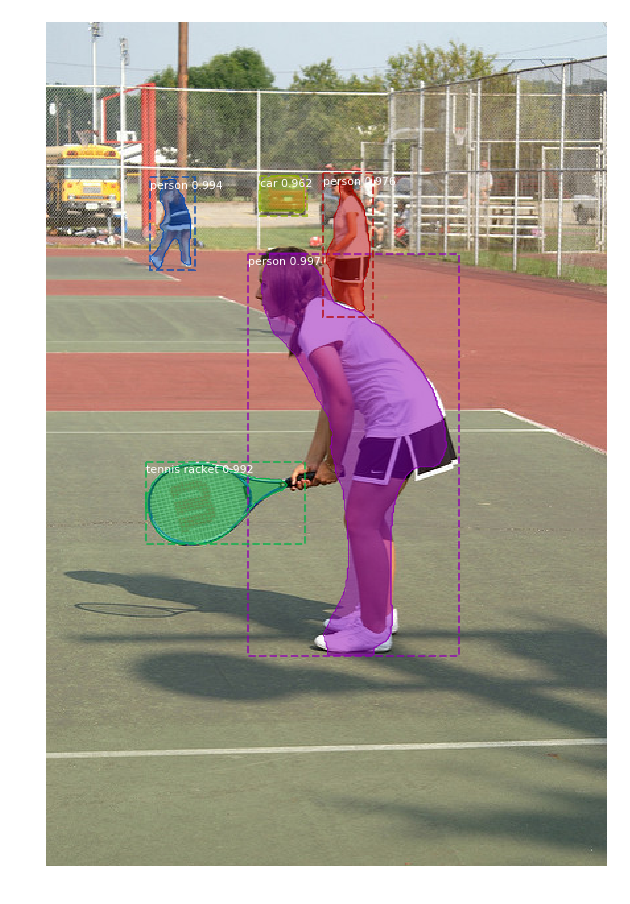

In [15]:
# Load a random image from the images folder
image_dir = os.path.join(MODEL_DIR, "images")
file_names = next(os.walk(image_dir))[2]
image = scipy.misc.imread(os.path.join(image_dir, random.choice(file_names)))

results = model.detect([image], verbose=1)

r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])